In [44]:
# https://linuxtut.com/en/158f004de6d243e3aeae/
import numpy as np
import pandas as pd
import MeCab
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


In [45]:
df = pd.read_csv("2022/kokkai_speech_20221.csv")
df = df[df["発言者名"]!="会議情報"]

In [46]:
# https://github.com/neologd/mecab-ipadic-neologd/wiki/Regexp
# encoding: utf8
from __future__ import unicode_literals
import re
import unicodedata

def remove_speaker(s):
    sep = " "
    s1 = s.split(sep)[0]
    s2 = sep.join(s.split(sep)[1:])
    if "委員長" in s1 or "議長" in s1:
        return ""
    return s2

def unicode_normalize(cls, s):
    pt = re.compile('([{}]+)'.format(cls))

    def norm(c):
        return unicodedata.normalize('NFKC', c) if pt.match(c) else c

    s = ''.join(norm(x) for x in re.split(pt, s))
    s = re.sub('－', '-', s)
    return s

def remove_extra_spaces(s):
    s = re.sub('[ 　]+', ' ', s)
    blocks = ''.join(('\u4E00-\u9FFF',  # CJK UNIFIED IDEOGRAPHS
                      '\u3040-\u309F',  # HIRAGANA
                      '\u30A0-\u30FF',  # KATAKANA
                      '\u3000-\u303F',  # CJK SYMBOLS AND PUNCTUATION
                      '\uFF00-\uFFEF'   # HALFWIDTH AND FULLWIDTH FORMS
                      ))
    basic_latin = '\u0000-\u007F'

    def remove_space_between(cls1, cls2, s):
        p = re.compile('([{}]) ([{}])'.format(cls1, cls2))
        while p.search(s):
            s = p.sub(r'\1\2', s)
        return s

    s = remove_space_between(blocks, blocks, s)
    s = remove_space_between(blocks, basic_latin, s)
    s = remove_space_between(basic_latin, blocks, s)
    return s

def normalize_neologd(s):
    s = remove_speaker(s)
    s = s.strip()
    s = unicode_normalize('０-９Ａ-Ｚａ-ｚ｡-ﾟ', s)

    def maketrans(f, t):
        return {ord(x): ord(y) for x, y in zip(f, t)}

    s = re.sub('[˗֊‐‑‒–⁃⁻₋−]+', '-', s)  # normalize hyphens
    s = re.sub('[﹣－ｰ—―─━ー]+', 'ー', s)  # normalize choonpus
    s = re.sub('[~∼∾〜〰～]', '', s)  # remove tildes
    s = s.translate(
        maketrans('!"#$%&\'()*+,-./:;<=>?@[¥]^_`{|}~｡､･｢｣',
              '！”＃＄％＆’（）＊＋，－．／：；＜＝＞？＠［￥］＾＿｀｛｜｝〜。、・「」'))

    s = remove_extra_spaces(s)
    s = unicode_normalize('！”＃＄％＆’（）＊＋，－．／：；＜＞？＠［￥］＾＿｀｛｜｝〜', s)  # keep ＝,・,「,」
    s = re.sub('[’]', '\'', s)
    s = re.sub('[”]', '"', s)
    return s

In [49]:
#  https://aidemy.net/magazine/688/
def sloth():
    import urllib3
    from bs4 import BeautifulSoup

    slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    http = urllib3.PoolManager()
    #↑urlib3系のおまじない
    slothlib_file =http.request('GET',slothlib_path)
    soup=BeautifulSoup(slothlib_file.data,'lxml')
    soup=str(soup).split()#soupは文字列じゃないので注意
    #SlothLibに存在しないストップワードを自分で追加↓
    # mydict=['いる','内閣総理大臣','おり','ない','あり','ある','いく','なっ','する','あっ','君','総理','の','委員長','委員','ん','ふう','指名','質問','質疑','大臣','指摘','異議','強力','理事','いかが','拍手','政府参考人','協力','答弁','員数']
    # soup.extend(mydict)
    return soup

In [50]:
stop_word = sloth()

In [51]:
speakers = [speaker for speaker in df["発言者名"]]

## 形態素解析

In [52]:
text = df["発言内容"].apply(normalize_neologd)
mecab = MeCab.Tagger('-d /Users/ayakowatanabe/opt/anaconda3/lib/mecab/dic/mecab-ipadic-neologd')
mecab_text = [mecab.parse(t).strip() for t in text]

In [53]:
text

0       午後一時開議出席委員委員長根本匠君理事今枝宗一郎君理事島尻安伊子君理事谷公一君理事西村康稔君...
1                                                        
2                                                        
3                                                        
4                                                        
                              ...                        
2185    そういう意味でいうと、総理がおっしゃっているように、この間、医療体制等々を整えるための時間と...
2186    そこで、第五波では自宅療養者が最大十三万人になりました。保健所、病院にもつながらないまま在宅...
2187                                                     
2188                                                     
2189                                                     
Name: 発言内容, Length: 2190, dtype: object

In [54]:
all = []
for line in mecab_text:
    morphemes = []
    # 表層形はtab区切り、それ以外は','区切りでバラす
    cols = line.split('\n')
    for col in cols:
        c = col.split('\t')
        if(len(c) < 2):
            continue
        res_cols = c[1].split(',')

        # 辞書作成、リストに追加
        # POS Tagging
        morpheme = {
            'surface': c[0],
            'pos': res_cols[0],
            'pos1': res_cols[1],
            'pos2' : res_cols[2],
            'base': res_cols[6]
        }
        morphemes.append(morpheme)
    all.append(morphemes)

In [55]:
# https://qiita.com/8_hisakichi_8/items/d6894803d2ebabf3d33b
# word_counter = dict()
# for line in all:
#     for morphemes in line:
#         if morphemes['pos'] == '名詞':
#             if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and not any([morphemes["pos1"] == ck_sp for ck_sp in ["非自立","代名詞","数","副詞可能","接尾"]]) and morphemes["pos2"] != "人名":
#                 #リストに入れないと、１文字づつカウントしてしまう
#                 word_counter[morphemes['surface']] = word_counter.get(morphemes['surface'], 0) + 1
#         if any([morphemes["pos"] == ck_sp for ck_sp in ["動詞", "形容詞"]]):
#             if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and morphemes["pos1"] == "自立":
#                 word_counter[morphemes['base']] = word_counter.get(morphemes['base'], 0) + 1

word_counter = []
for line in all:
    for morphemes in line:
        if morphemes['pos'] == '名詞':
            if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and not any([morphemes["pos1"] == ck_sp for ck_sp in ["非自立","代名詞","数","副詞可能","接尾"]]) and morphemes["pos2"] != "人名":
                #リストに入れないと、１文字づつカウントしてしまう
                word_counter.append(morphemes['surface'])
        # if any([morphemes["pos"] == ck_sp for ck_sp in ["動詞", "形容詞"]]):
        #     if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and morphemes["pos1"] == "自立":
        #         word_counter.append(morphemes['base'])

### Word Count

In [56]:
# sort_word_counter = sorted(word_counter.items(), key=lambda kv: kv[1], reverse=True)
# sort_word_counter

fdist = Counter(word_counter)
fdist.most_common(50)

[('総理', 875),
 ('必要', 607),
 ('対応', 522),
 ('日本', 500),
 ('状況', 493),
 ('政府', 488),
 ('国民', 432),
 ('経済', 429),
 ('支援', 428),
 ('問題', 414),
 ('重要', 375),
 ('対策', 361),
 ('議論', 355),
 ('接種', 351),
 ('指摘', 345),
 ('質問', 342),
 ('統計', 339),
 ('予算', 337),
 ('株', 329),
 ('体制', 329),
 ('実現', 325),
 ('取組', 323),
 ('検討', 309),
 ('ワクチン', 305),
 ('オミクロン', 303),
 ('検査', 295),
 ('確保', 294),
 ('強化', 290),
 ('理事', 285),
 ('大臣', 283),
 ('令和', 281),
 ('課題', 277),
 ('制度', 277),
 ('社会', 274),
 ('委員', 271),
 ('感染', 262),
 ('お願い', 259),
 ('子供', 255),
 ('成長', 253),
 ('措置', 241),
 ('自治体', 239),
 ('政策', 238),
 ('地域', 236),
 ('答弁', 233),
 ('皆さん', 232),
 ('医療', 228),
 ('デジタル', 219),
 ('活用', 219),
 ('我が国', 218),
 ('ー', 217)]

In [57]:
# https://qiita.com/8_hisakichi_8/items/d6894803d2ebabf3d33b
word_lst = []
w_lst = []
for line in all:
    each_row = []
    for morphemes in line:
        if morphemes['pos'] == '名詞':
            if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and not any([morphemes["pos1"] == ck_sp for ck_sp in ["非自立","代名詞","数","副詞可能","接尾"]]) and morphemes["pos2"] != "人名":
                #リストに入れないと、１文字づつカウントしてしまう
                each_row.append(morphemes['surface'])
        # if any([morphemes["pos"] == ck_sp for ck_sp in ["動詞", "形容詞"]]):
        #     if not morphemes['surface'] in stop_word and not morphemes['surface'] in speakers and morphemes["pos1"] == "自立":
        #     # lemmatization
        #         each_row.append(morphemes['base'])
    w_lst.append(each_row)
    s = ' '.join(each_row)
    word_lst.append(s)


In [58]:
count = CountVectorizer(max_df=0.1, max_features=5000)
bag = count.fit_transform(word_lst)
count_index = count.vocabulary_

## TF-IDF

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)

tf = tfidf.fit_transform(count.fit_transform(word_lst)).toarray()

max_tf = tf.max(axis=0, keepdims=True)

In [60]:
max_tf.shape

(1, 5000)

In [61]:
final_dic = {}
for word, index in count_index.items():
    final_dic[word] = max_tf[0][index]

In [62]:
final_dic

{'出席': 0.44432510327546926,
 '委員': 1.0,
 '理事': 0.925362316263264,
 '石破茂': 0.11759882979231179,
 '内閣総理大臣': 0.16236875269038495,
 '総務大臣': 0.6471988550534364,
 '法務大臣': 0.2499307071120243,
 '財務大臣': 0.5829823309274882,
 '厚生労働大臣': 0.3938745517836554,
 '経済産業大臣': 0.22128040741491983,
 '国土交通大臣': 0.25406276682410395,
 '防衛大臣': 0.5148677080765441,
 '国務大臣': 0.5597089650461882,
 '男女共同参画': 0.1690717940349601,
 '担当': 0.5074905248788556,
 '資本主義': 0.42536064045543187,
 'ワクチン': 0.6461376681831693,
 '接種': 0.7343188993411672,
 '推進': 0.23917649207468952,
 '内閣府副大臣': 0.05152393790626532,
 '財務': 0.19084655691850597,
 '副大臣': 0.22486277643108604,
 '政府参考人': 0.8996321445491592,
 '内閣官房': 0.40755775397379657,
 '内閣': 0.33180691066133877,
 '審議官': 0.21435371974829198,
 '内閣府': 0.39354406872518144,
 '局長': 0.17197371694618094,
 '地方創生': 0.12058744006855114,
 '事務局': 0.28092571473855893,
 '科学技術': 0.46220726909144183,
 'イノベーション': 0.2335872236843034,
 '統括官': 0.10923367814341528,
 'デジタル': 0.5103877473756641,
 '総務省': 0.375198802

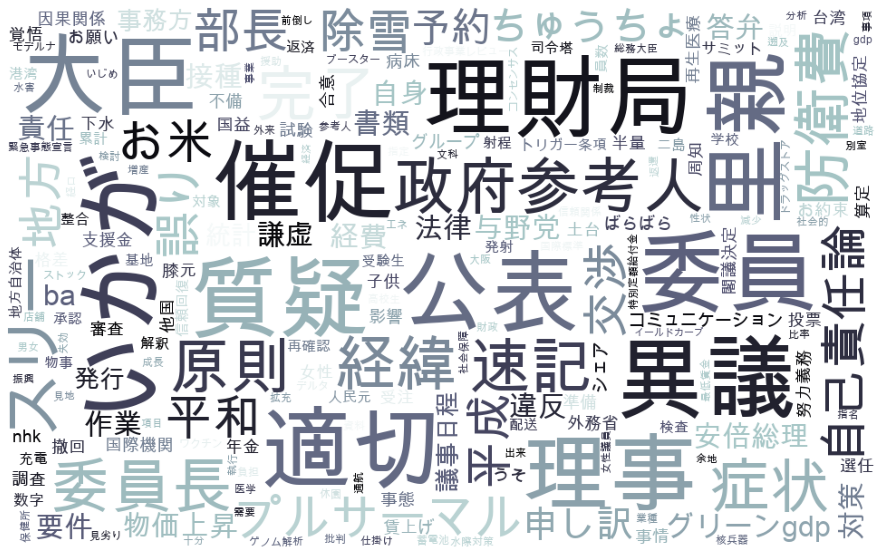

In [63]:
# from wordcloud import WordCloud

# #フォントをColabローカルにインストール
# # from google.colab import drive
# # drive.mount("/content/gdrive")
# # # 事前に自分のGoogleDriveのマイドライブのトップにfontというフォルダを作っておき、その中に所望のフォントファイルを入れておく
# # # フォルダごとColabローカルにコピー
# # !cp -a "gdrive/My Drive/font/" "/usr/share/fonts/"
# # インスタンスの生成（パラメータ設定）
# wordcloud = WordCloud(
#     width=960, height=600,   # 生成画像のサイズの指定
#     background_color="white",   # 意図的に表示しない単語
#     max_words=350,   # 最大単語数
#     max_font_size=100, min_font_size=5,   # フォントサイズの範囲
#     collocations = False    # 複合語の表示
#     )

# wc = wordcloud.generate_from_frequencies(final_dic)  # ←ワードクラウドの生成
# wc.to_image()

from matplotlib import pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(width=960, height=600, background_color='white', colormap='bone', font_path='/Library/Fonts/Arial Unicode.ttf',  max_font_size=100, min_font_size=5, collocations = False).fit_words(final_dic)
plt.figure( figsize=(20,10) )
plt.imshow(cloud)
plt.axis('off')
plt.show()

## LDA

In [64]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123,
                                learning_method='batch')
bag_topics = lda.fit_transform(bag)

In [65]:
# https://github.com/rasbt/machine-learning-book/blob/main/ch08/ch08.ipynb
n_top_words = 5
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {(topic_idx + 1)}:')
    print(' '.join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
日本 体制 強化 取組 重要
Topic 2:
オミクロン 防止 措置 対策 感染
Topic 3:
検査 感染 濃厚接触者 体制 検査キット
Topic 4:
成長 経済 資本主義 分配 実現
Topic 5:
大臣 数字 令和 紹介 確認
Topic 6:
接種 ワクチン 自治体 お尋ね 検討
Topic 7:
支援 給付 制度 事業 日本
Topic 8:
子供 家庭 議論 こども 教育
Topic 9:
統計 調査 受注 問題 検討
Topic 10:
理事 委員長 委員 政府参考人 令和


## Similarity Scores

In [66]:

df_similarities = pd.read_csv("2022/kokkai_speech_20221.csv")
df_similarities = df_similarities[["発言ID","会議名", "日付", "発言者名", "発言内容"]]
df_text = pd.Series(word_lst)
df_similarities["Processed"] = df_text
df_similarities["Processed"] = df_similarities["Processed"].fillna(0)

In [67]:

def cos_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    if np.all(norm_u==0.0) or np.all(norm_v==0.0):
        return None
    return dot / np.dot(norm_u, norm_v)

def best_similarity(x_tf, j):
    best_sim = -1
    best = None
    for i, y_tf in enumerate(tf):
        if i == j:
            continue
        sim = cos_similarity(y_tf, x_tf)
        if sim is not None and sim > best_sim:
            best = i
            best_sim = sim
    if best is None:
        return 0
    return best


In [68]:
sims = np.array([best_similarity(v, i) for i,v in enumerate(tf)])

In [69]:
similar_text = []
for s in sims:
    similar_text.append(df_similarities.loc[s, "発言内容"])

In [70]:
df_similarities["Similar"] = pd.Series(similar_text)
df_similarities = df_similarities[df_similarities["Processed"] != '']
df_similarities[["発言内容","Similar"]].to_csv('テスト.csv')
df_similarities

,発言ID,会議名,日付,発言者名,発言内容,Processed,Similar
0,120805261X00620220131_000,予算委員会,2022-01-31,会議録情報,令和四年一月三十一日（月曜日） 午後一時開議 出席委員 委員長 根本 匠君...,議 出席 委員 理事 理事 理事 理事 理事 理事 理事 理事 理事 石破茂 内閣総理大臣 ...,令和四年一月二十八日（金曜日） 午前九時開議 出席委員 委員長 根本 匠君...
5,120805261X00620220131_005,予算委員会,2022-01-31,葉梨康弘,○葉梨委員 自由民主党の葉梨康弘です。 早速質問に入ります。 今国会は、建設業者が毎月ど...,質問 国会 建設業者 工事 受注 建設工事 受注 動態 統計 データ 書換え 問題 書換え ...,○葉梨委員 確かに、元請がどれぐらい下請に回しているか、これを知るために、この統計では元請額...
7,120805261X00620220131_007,予算委員会,2022-01-31,葉梨康弘,○葉梨委員 確かに、元請がどれぐらい下請に回しているか、これを知るために、この統計では元請額...,パネル 茨城 国光 議員 お願い 冒頭 問題 建設工事 受注 動態 統計 建設工事 発注 着...,○高田政府参考人 お答え申し上げます。 建設工事受注動態統計調査は建設業者の受注額を把握す...
8,120805261X00620220131_008,予算委員会,2022-01-31,高田陽介,○高田政府参考人 お答え申し上げます。 委員御指摘のとおり、建設工事受注動態統計調査は、平...,委員 指摘 建設工事 受注 動態 統計 調査 平成 回収 逆数 欠 値 補完 推計 開始 他...,○高田政府参考人 お答え申し上げます。 建設工事受注動態統計調査は建設業者の受注額を把握す...
9,120805261X00620220131_009,予算委員会,2022-01-31,葉梨康弘,○葉梨委員 いや、そのとおりなんですが、こういう答弁だから、この統計の問題というのはなかなか...,係数 受注 GDP 係数 データ 比較 係数 比較 平成 資料 GDP かさ上げ 意図 係数...,○近藤（和）委員 現時点においてはということで答弁を全て正当化されれば、この国会での質疑がお...
...,...,...,...,...,...,...,...
2182,120714024X00120220107_039,議院運営委員会,2022-01-07,倉林明子,○倉林明子君 日本共産党の倉林です。 総理は今月五日に、厳しい水際対策で時間を稼いでいる間...,総理 水際対策 国内 感染 増加 準備 水際対策 米軍 大穴 放置 実態 明らか 感染 拡大...,○国務大臣（山際大志郎君） 三回目のブースター接種でございますけれども、令和四年、今年の一月...
2183,120714024X00120220107_040,議院運営委員会,2022-01-07,山際大志郎,○国務大臣（山際大志郎君） 三回目のブースター接種でございますけれども、令和四年、今年の一月...,メルク 経口 治療薬 モルヌピラビル 一月六日 医療機関 薬局 登録 医療機関 薬局 薬剤 配送,○後藤国務大臣 自宅療養が、しっかりと医療が始まるということは、昨年の夏の経験から考えても、...
2184,120714024X00120220107_041,議院運営委員会,2022-01-07,倉林明子,○倉林明子君 これ、追加接種の状況の終了の見通しということで今示せていないという状況にあろう...,全国 診療所 薬局 登録 現状 感染 拡大 準備 認識 政府 必要 陽性 速やか 発見 隔離...,○岸田内閣総理大臣 まず、新型コロナへの対応は、政権の最優先課題であり、最悪の事態を想定して...
2185,120714024X00120220107_042,議院運営委員会,2022-01-07,山際大志郎,○国務大臣（山際大志郎君） 検査に関しては、ファクトとして、事実として、もう現段階で四十四都...,意味 総理 医療 体制 十分 十分 拡充 認識 オペレーション 物事 物事 認識,○山際国務大臣 常に問題というものはずっとあり続けるんだと思っておりまして、結局、森羅万象、...


大臣答弁が近い関係になってる。

## Word2Vec

https://github.com/PacktPublishing/Hands-On-Python-Natural-Language-Processing/tree/master/Chapter05

In [71]:
from gensim.models import Word2Vec
model = Word2Vec(w_lst, min_count=1, vector_size = 300)

In [72]:
print(model.vector_size)
# print(model.wv.key_to_index)
# print(model.wv.index_to_key)

300


In [73]:
model.init_sims(replace=True)

/var/folders/f4/d26fc2lx7y5d0rs_6sbh_b2h0000gn/T/ipykernel_48081/1992334471.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [74]:
vector = model.wv['自治体']
vector

array([-0.01603516,  0.09159458,  0.00498389,  0.01051954,  0.00083828,
       -0.03341964,  0.05765866,  0.15979096,  0.05499457, -0.03279753,
       -0.02019421, -0.07479641, -0.01118556, -0.0345128 , -0.07355457,
       -0.07990514,  0.06077365,  0.00252573,  0.02186632,  0.00989646,
       -0.06628841,  0.03457928,  0.05418596, -0.01680076,  0.08341081,
        0.0185807 , -0.10228091, -0.01747883, -0.03614382, -0.14304096,
        0.03340793, -0.02231974, -0.00814559,  0.07420707, -0.02422529,
        0.02350089,  0.03643405, -0.08410528,  0.00204524, -0.04775194,
       -0.01445326,  0.05373549, -0.01084171, -0.04201144,  0.03352431,
        0.06292403,  0.05789984,  0.03145104, -0.04062069,  0.08512696,
        0.00025686,  0.01471657, -0.00150104,  0.0235121 , -0.01698864,
        0.10042066,  0.03179386,  0.01218155,  0.01870237, -0.03588673,
       -0.04731689, -0.04726582,  0.04247359,  0.01276471,  0.02657192,
       -0.02645255,  0.00410815,  0.02447265, -0.00071412, -0.03

In [75]:
model.wv.most_similar('接種', topn=10)

[('ワクチン', 0.9989602565765381),
 ('ブースター', 0.9959824085235596),
 ('間隔', 0.9956846833229065),
 ('体制', 0.995644748210907),
 ('医療', 0.9934657216072083),
 ('交互', 0.9932422041893005),
 ('検査', 0.9924286007881165),
 ('状況', 0.9907947778701782),
 ('拡大', 0.9905623197555542),
 ('感染', 0.9905231595039368)]

In [76]:
from gensim.models import keyedvectors
model.wv.wmdistance('これからが我が国において三回目の接種は本格化する時期であると思っております', 'しっかりと前向きに接種に努めてもらいたい')

0.11827929611931833

In [77]:
model.wv.wmdistance('接種','ブースター')

0.7718262142566702

## Doc2Vec

https://github.com/PacktPublishing/Hands-On-Python-Natural-Language-Processing/tree/master/Chapter06

In [78]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(w_lst)]

In [79]:
documents[:5]

[TaggedDocument(words=['議', '出席', '委員', '理事', '理事', '理事', '理事', '理事', '理事', '理事', '理事', '理事', '石破茂', '内閣総理大臣', '総務大臣', '法務大臣', '財務大臣', '厚生労働大臣', '経済産業大臣', '国土交通大臣', '防衛大臣', '国務大臣', '男女共同参画', '担当', '国務大臣', '資本主義', '担当', '国務大臣', 'ワクチン', '接種', '推進', '担当', '国務大臣', '内閣府副大臣', '財務', '副大臣', '政府参考人', '内閣官房', '内閣', '審議官', '政府参考人', '内閣府', '男女共同参画', '局長', '政府参考人', '内閣府', '地方創生', '推進', '事務局', '審議官', '政府参考人', '内閣府', '科学技術', 'イノベーション', '推進', '事務局', '統括官', '政府参考人', 'デジタル', '審議官', '政府参考人', '総務省', '総合通信基盤局', '政府参考人', '法務省', '民事', '局長', '政府参考人', '法務省', '人権擁護', '局長', '政府参考人', '外務省', '総合外交政策局', '軍縮', '拡散', '科学', '部長', '政府参考人', '外務省', '北米', '局長', '政府参考人', '財務省大臣官房', '政府参考人', '財務省', '理財', '局長', '政府参考人', '厚生労働省', '健康局', '政府参考人', '厚生労働省', '政策統括官', '政府参考人', '経済産業省大臣官房', '審議官', '政府参考人', '経済産業省', '商務情報政策局', '政府参考人', '資源エネルギー庁', '長官', '官房', '資源', 'エネルギー政策', '統括', '調整', '政府参考人', '資源エネルギー庁', '資源', '燃料', '部長', '政府参考人', '資源エネルギー庁', '電力', 'ガス事業', '部長', '政府参考人', '国土交通省大臣官房', '政策', '立案', '総括', '審議官', '政府参考人', '国土交通省総合政策局

In [80]:
model = Doc2Vec(documents,vector_size=50, min_count=3, workers=40, epochs=40)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [81]:
print(model.vector_size, len(model.docvecs), len(model.wv.key_to_index))

50 2190 4238


/var/folders/f4/d26fc2lx7y5d0rs_6sbh_b2h0000gn/T/ipykernel_48081/1240014532.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  print(model.vector_size, len(model.docvecs), len(model.wv.key_to_index))


In [82]:
model.infer_vector(['必要','取組'])

array([ 0.14785433,  0.08735023, -0.07969328, -0.02955718,  0.07284623,
        0.00942012, -0.08360493,  0.19395593, -0.253523  , -0.0140966 ,
       -0.14691524,  0.08122381,  0.22136451, -0.10208917, -0.14348757,
        0.21181609,  0.12597251,  0.26835695, -0.0434826 , -0.2089559 ,
       -0.35250056,  0.03192383,  0.24287252, -0.04367552,  0.0124765 ,
        0.08240705,  0.07945106, -0.04831924, -0.24580842,  0.57261395,
        0.12880956, -0.07923291,  0.26586166,  0.12292282, -0.02440203,
        0.24722631,  0.20846422, -0.01715066,  0.01852361,  0.04747257,
       -0.11797059, -0.01359806,  0.36184147, -0.21576825,  0.11775294,
       -0.13224591, -0.12632261, -0.35962972,  0.2429967 ,  0.2082848 ],
      dtype=float32)

## fastText

In [83]:
from gensim.models import FastText

model = FastText(vector_size=5, window=3, min_count=1, min_n=1, max_n=5)
model.build_vocab(w_lst)
model.train(w_lst, total_examples=len(w_lst), epochs=10)

(884975, 919420)

In [84]:
model.wv['感染症']

array([-2.6099966, -2.942159 ,  2.55136  , -4.0481954,  3.321522 ],
      dtype=float32)

In [85]:
model.wv.most_similar(positive=['感染症','接種','オミクロン'])

[('症状', 0.9932824373245239),
 ('濃厚接触者', 0.9928033351898193),
 ('重症', 0.991724967956543),
 ('濃厚接触', 0.9913313388824463),
 ('感染予防', 0.9903313517570496),
 ('感染者', 0.9848290085792542),
 ('脳症', 0.9838744401931763),
 ('患者', 0.9830895662307739),
 ('五類感染症', 0.9830144643783569),
 ('新規感染者', 0.9822806715965271)]

In [86]:
model.wv.most_similar('緊迫')

[('面倒', 0.9990336894989014),
 ('反応', 0.9989274740219116),
 ('登録販売者', 0.9988294243812561),
 ('拙速', 0.998771071434021),
 ('健康観察', 0.9987083077430725),
 ('運転者', 0.9984766244888306),
 ('間口', 0.9984673857688904),
 ('輸送機', 0.998204231262207),
 ('早急', 0.9979331493377686),
 ('後ろ倒し', 0.9979124665260315)]

In [87]:
model.wv.wmdistance('これからが我が国において三回目の接種は本格化する時期であると思っております', 'しっかりと前向きに接種に努めてもらいたい')

0.1298139166725574